In [1]:
import pandas as pd
import codecs
import re
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
%matplotlib inline

In [2]:
import sys
import warnings

warnings.filterwarnings("ignore", category = DeprecationWarning) 
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
with codecs.open("lyrics.csv", "r", "Shift-JIS", "ignore") as file:
    df = pd.read_csv(file, delimiter=",")
    
print(len(df))
df.head()

362237


,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [4]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r'(', '') 
    df[text_field] = df[text_field].str.replace(r')', '')
    df[text_field] = df[text_field].str.replace(r',', '')
    df[text_field] = df[text_field].str.replace(r'_', '')
    df[text_field] = df[text_field].str.replace(r"'", "")
    df[text_field] = df[text_field].str.replace('\n','')
    df[text_field] = df[text_field].str.replace('\t','')
    df[text_field] = df[text_field].str.replace(r"^[a-z]+\[0-9]\d+", "")
    df[text_field] = df[text_field].str.replace(r"^[0-9]{1,2,3,4,5}?$", "")
    return df

In [5]:
df = standardize_text(df, 'lyrics')
df = df[pd.notnull(df['lyrics'])]

In [6]:
lyrics = df['lyrics'].apply(str).values
genre = df['genre'].apply(str).values

lyrics_train, lyrics_test, genre_train, genre_test = train_test_split(lyrics, genre, test_size = 0.20, random_state = 1000)

In [7]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)

plt.figure(figsize = (10,4))
# print(df.genre.value_counts())
df.genre.value_counts().sort_values(ascending = False).iplot(kind = 'bar', title = 'Number of songs in each genre');

<Figure size 720x288 with 0 Axes>

In [8]:
# Naive Bayes Classifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = ["Rock", "Pop", "Hip-Hop", "Not Available", "Metal", "Other", 
           "Country", "Jazz", "Electronic", "R&B", "Indie", "Folk"]
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(lyrics_train, genre_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(lyrics_test)

print('accuracy %s' % accuracy_score(y_pred, genre_test))
print(classification_report(genre_test, y_pred,target_names = my_tags))

accuracy 0.42821503601440575
               precision    recall  f1-score   support

         Rock       0.00      0.00      0.00      2852
          Pop       0.00      0.00      0.00      1597
      Hip-Hop       0.00      0.00      0.00       456
Not Available       0.93      0.07      0.13      4945
        Metal       0.00      0.00      0.00       627
        Other       0.00      0.00      0.00      1582
      Country       1.00      0.00      0.01      4780
         Jazz       0.54      0.04      0.08      4768
   Electronic       0.00      0.00      0.00       975
          R&B       0.39      0.10      0.16      8168
        Indie       0.00      0.00      0.00       651
         Folk       0.43      0.98      0.59     21911

     accuracy                           0.43     53312
    macro avg       0.27      0.10      0.08     53312
 weighted avg       0.46      0.43      0.29     53312



In [9]:
# Linear Support Vector Machine

from sklearn.linear_model import SGDClassifier

my_tags = ["Rock", "Pop", "Hip-Hop", "Not Available", "Metal", "Other", 
           "Country", "Jazz", "Electronic", "R&B", "Indie", "Folk"]
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(lyrics_train, genre_train)

y_pred = sgd.predict(lyrics_test)

print('accuracy %s' % accuracy_score(y_pred, genre_test))
print(classification_report(genre_test, y_pred,target_names=my_tags))

accuracy 0.5024572328931572
               precision    recall  f1-score   support

         Rock       0.40      0.11      0.18      2852
          Pop       0.27      0.03      0.05      1597
      Hip-Hop       0.35      0.04      0.06       456
Not Available       0.54      0.81      0.65      4945
        Metal       0.03      0.00      0.01       627
        Other       0.40      0.11      0.17      1582
      Country       0.63      0.35      0.45      4780
         Jazz       0.45      0.10      0.17      4768
   Electronic       0.25      0.05      0.08       975
          R&B       0.43      0.15      0.23      8168
        Indie       0.03      0.04      0.03       651
         Folk       0.51      0.85      0.64     21911

     accuracy                           0.50     53312
    macro avg       0.36      0.22      0.23     53312
 weighted avg       0.47      0.50      0.43     53312



In [10]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

my_tags = ["Rock", "Pop", "Hip-Hop", "Not Available", "Metal", "Other", 
           "Country", "Jazz", "Electronic", "R&B", "Indie", "Folk"]
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(lyrics_train, genre_train)

y_pred = logreg.predict(lyrics_test)

print('accuracy %s' % accuracy_score(y_pred, genre_test))
print(classification_report(genre_test, y_pred,target_names = my_tags))

accuracy 0.5567226890756303
               precision    recall  f1-score   support

         Rock       0.48      0.38      0.43      2852
          Pop       0.49      0.17      0.25      1597
      Hip-Hop       0.49      0.14      0.21       456
Not Available       0.80      0.76      0.78      4945
        Metal       0.32      0.06      0.10       627
        Other       0.45      0.29      0.35      1582
      Country       0.64      0.49      0.56      4780
         Jazz       0.34      0.23      0.27      4768
   Electronic       0.30      0.12      0.17       975
          R&B       0.44      0.41      0.42      8168
        Indie       0.44      0.16      0.24       651
         Folk       0.58      0.78      0.66     21911

     accuracy                           0.56     53312
    macro avg       0.48      0.33      0.37     53312
 weighted avg       0.54      0.56      0.53     53312



In [11]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize = (10,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

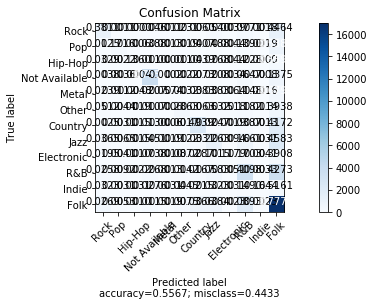

In [12]:
plot_confusion_matrix(cm           = confusion_matrix(genre_test, y_pred), 
                      normalize    = True,
                      target_names = my_tags,
                      title        = "Confusion Matrix")

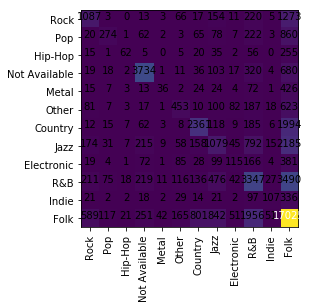

In [13]:
import numpy as np
import itertools

plt.figure(figsize = (10,4))
ar = confusion_matrix(genre_test, y_pred)
plt.imshow(ar)
tick_marks = np.arange(len(my_tags))
plt.xticks(tick_marks, my_tags, rotation=90)
plt.yticks(tick_marks, my_tags)


thresh = ar.max() / 2.
for i, j in itertools.product(range(ar.shape[0]), range(ar.shape[1])):
    plt.text(j, i, ar[i, j],horizontalalignment="center", color="white" if ar[i, j] > thresh else "black")

In [14]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(lyrics)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 2299249 unique tokens.


In [15]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['lyrics'].apply(str).values)
X = pad_sequences(X, maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (266557, 250)


In [16]:
Y = pd.get_dummies(df['genre']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (266557, 12)


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(239901, 250) (239901, 12)
(26656, 250) (26656, 12)


In [18]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout1D
from keras.layers import Embedding
from keras.layers import LSTM,Bidirectional
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.engine import Input
from keras.optimizers import SGD
from keras.preprocessing import text,sequence
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

In [19]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Convolution1D(filters = 150,
                        kernel_size = 3,
                        border_mode = 'same',
                        activation = 'relu',
                        subsample_length = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(12, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    validation_split = 0.1, 
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.0001)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 215910 samples, validate on 23991 samples
Epoch 1/5
215910/215910 [==============================] - 583s 3ms/step - loss: 1.5667 - acc: 0.5029 - val_loss: 1.4790 - val_acc: 0.5290
Epoch 2/5
215910/215910 [==============================] - 575s 3ms/step - loss: 1.3901 - acc: 0.5592 - val_loss: 1.4497 - val_acc: 0.5363
Epoch 3/5
215910/215910 [==============================] - 575s 3ms/step - loss: 1.2629 - acc: 0.6029 - val_loss: 1.4454 - val_acc: 0.5429
Epoch 4/5
215910/215910 [==============================] - 576s 3ms/step - loss: 1.1297 - acc: 0.6459 - val_loss: 1.5085 - val_acc: 0.5380
Epoch 5/5
215910/215910 [==============================] - 575s 3ms/step - loss: 0.9937 - acc: 0.6893 - val_loss: 1.5768 - val_acc: 0.5304


In [20]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

26656/26656 [==============================] - 59s 2ms/step
Test set
  Loss: 1.579
  Accuracy: 0.529


In [21]:
plt.style.use('ggplot')

def plot_history_ggplot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

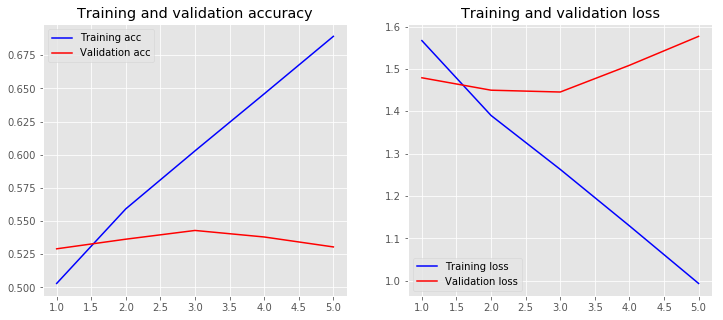

In [22]:
plot_history_ggplot(history)

In [23]:
import numpy as np

new_lyrics = [   
    "All my life I've been a good girl\
    Tryna do what's right, never told no lies\
    Then you came around and suddenly my world\
    Turned upside down, now there's no way out\
    I tried to fight against it, shut out what all my friends said\
    Can't get you out of my head, oh-woah-woah-woah-woah\
    I keep letting you in, though I know it's not a good thing\
    I got you under my skin, oh-woah-woah-woah\
    You're so outta line\
    You make me bad and I don't know why\
    But that's what I like about ya\
    Yeah, that's what I like about ya\
    I'm out of my mind\
    You got me runnin' all the red lights\
    But that's what I like about ya\
    Yeah, that's what I like about ya\
    That's what I like about ya\
    (Ooh) Yeah, that's what I like about ya\
    (Ooh, make me bad and I don't know)\
    (Ooh, make me bad and I don't know)\
    (Ooh) That's what I like about ya\
    (Ooh) Yeah, that's what I like about ya\
    I don't care if my daddy don't think we're the perfect pair\
    It's my affair\
    Yeah, I don't know why my momma worries when I'm out all night\
    She thinks I'm nine, uh-uh\
    I tried to fight against it, shut out what all my friends said\
    Can't get you out of my head, oh-woah-woah-woah-woah\
    I keep letting you in, though I know it's not a good thing\
    I got you under my skin, oh-woah-woah-woah\
    You're so outta line\
    You make me bad and I don't know why\
    But that's what I like about ya\
    Yeah, that's what I like about ya\
    I'm out of my mind\
    You got me runnin' all the red lights\
    But that's what I like about ya\
    Yeah, that's what I like about ya\
    That's what I like about ya\
    (Ooh) Yeah, that's what I like about ya\
    (Ooh, make me bad and I don't know)\
    (Ooh, make me bad and I don't know)\
    (Ooh) That's what I like about ya\
    (Ooh) Yeah, that's what I like about ya\
    I'm a fool for you\
    I tried to fight against it, shut out what all my friends said\
    Can't get you out of my head (Out of my head, out of my head)\
    I keep letting you in, though I know it's not a good thing\
    I got you under my skin, oh-woah-woah-woah\
    You're so out of line (You're so outta line)\
    You make me bad and I don't know why (I don't know why)\
    But that's what I like about ya\
    Yeah, that's what I like about ya (Yeah, that's what I like)\
    I'm out of my mind\
    You got me runnin' all the red lights (You got me runnin')\
    But that's what I like about ya\
    Yeah, that's what I like about ya\
    That's what I like about ya\
    (Ooh) Yeah, that's what I like about ya\
    (Ooh, make me bad and I don't know)\
    (Ooh, make me bad and I don't know)\
    (Ooh) That's what I like about ya\
    (Ooh) Yeah, that's what I like about ya"]
seq = tokenizer.texts_to_sequences(new_lyrics)
padded = pad_sequences(seq, maxlen = MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
my_tags = ["Rock", "Pop", "Hip-Hop", "Not Available", "Metal", "Other", 
           "Country", "Jazz", "Electronic", "R&B", "Indie", "Folk"]

print(pred, my_tags[np.argmax(pred)])

[[0.00443605 0.11274784 0.00268884 0.01278187 0.02782017 0.00551375
  0.01185072 0.12756461 0.01382886 0.29636037 0.0140664  0.3703405 ]] Folk


In [25]:
from cleantext import clean
import unidecode

def plotSoftmaxProb(new_lyrics, title):
    clean("new_lyrics",
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    lang="en")
    # Convert texts into sequences and pad sentences 0
    seq = tokenizer.texts_to_sequences(new_lyrics)
    padded = pad_sequences(seq, maxlen = MAX_SEQUENCE_LENGTH)
    # Predict the genre of the song
    pred = model.predict(padded)
    # Make a flat list out of list of lists
    l = pred.tolist()
    flat_list = [item for sublist in l for item in sublist]
    # Put the probabilties from softmax layer into dataframe
    my_tags = ["Rock", "Pop", "Hip-Hop", "Not Available", "Metal", "Other", 
               "Country", "Jazz", "Electronic", "R&B", "Indie", "Folk"]
    data = {'genre' : pd.Series(flat_list, index = my_tags)}
    pred_df = pd.DataFrame(data)
    # Illustrate the probabilities
    pred_df.iplot(kind = 'bar', title = title);

In [26]:
plotSoftmaxProb(new_lyrics, title = 'Probability of genres for the testing lyric')

In [29]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [27]:
df_Rock = df[genre == "Rock"]

standardize_text(df_Rock, "lyrics")

df_Rock = df_Rock[pd.notnull(df_Rock['lyrics'])]
df_Rock.head()

,index,song,year,artist,genre,lyrics
404,404,hourglass,2004,borialis,Rock,a lot of cats are hatin slandering makin bad s...
407,407,why-oh-why,2004,borialis,Rock,somebody tell me why we landed here on the pla...
410,410,mightier-than-the-sword,2004,borialis,Rock,im spittin with the venomto your soul through ...
411,411,white-trash,2004,borialis,Rock,where should i begin cripplin all you villains...
412,412,don-t-mean-a-thing,2004,borialis,Rock,enough of all that lets switch up the formatan...
413,413,holocaust,2004,borialis,Rock,they say the ends nearbut ill approach it with...
463,463,sit-still,2007,brightwood,Rock,you cant sit still.i watched your movement fro...
464,464,surefire,2007,brightwood,Rock,looking back no turning back.wouldnt take it b...
465,465,taken,2007,brightwood,Rock,i am takeni am not my owni am floatingteach me...
466,466,swan-song,2010,brightwood,Rock,come alone and make noattempt to save yourself...


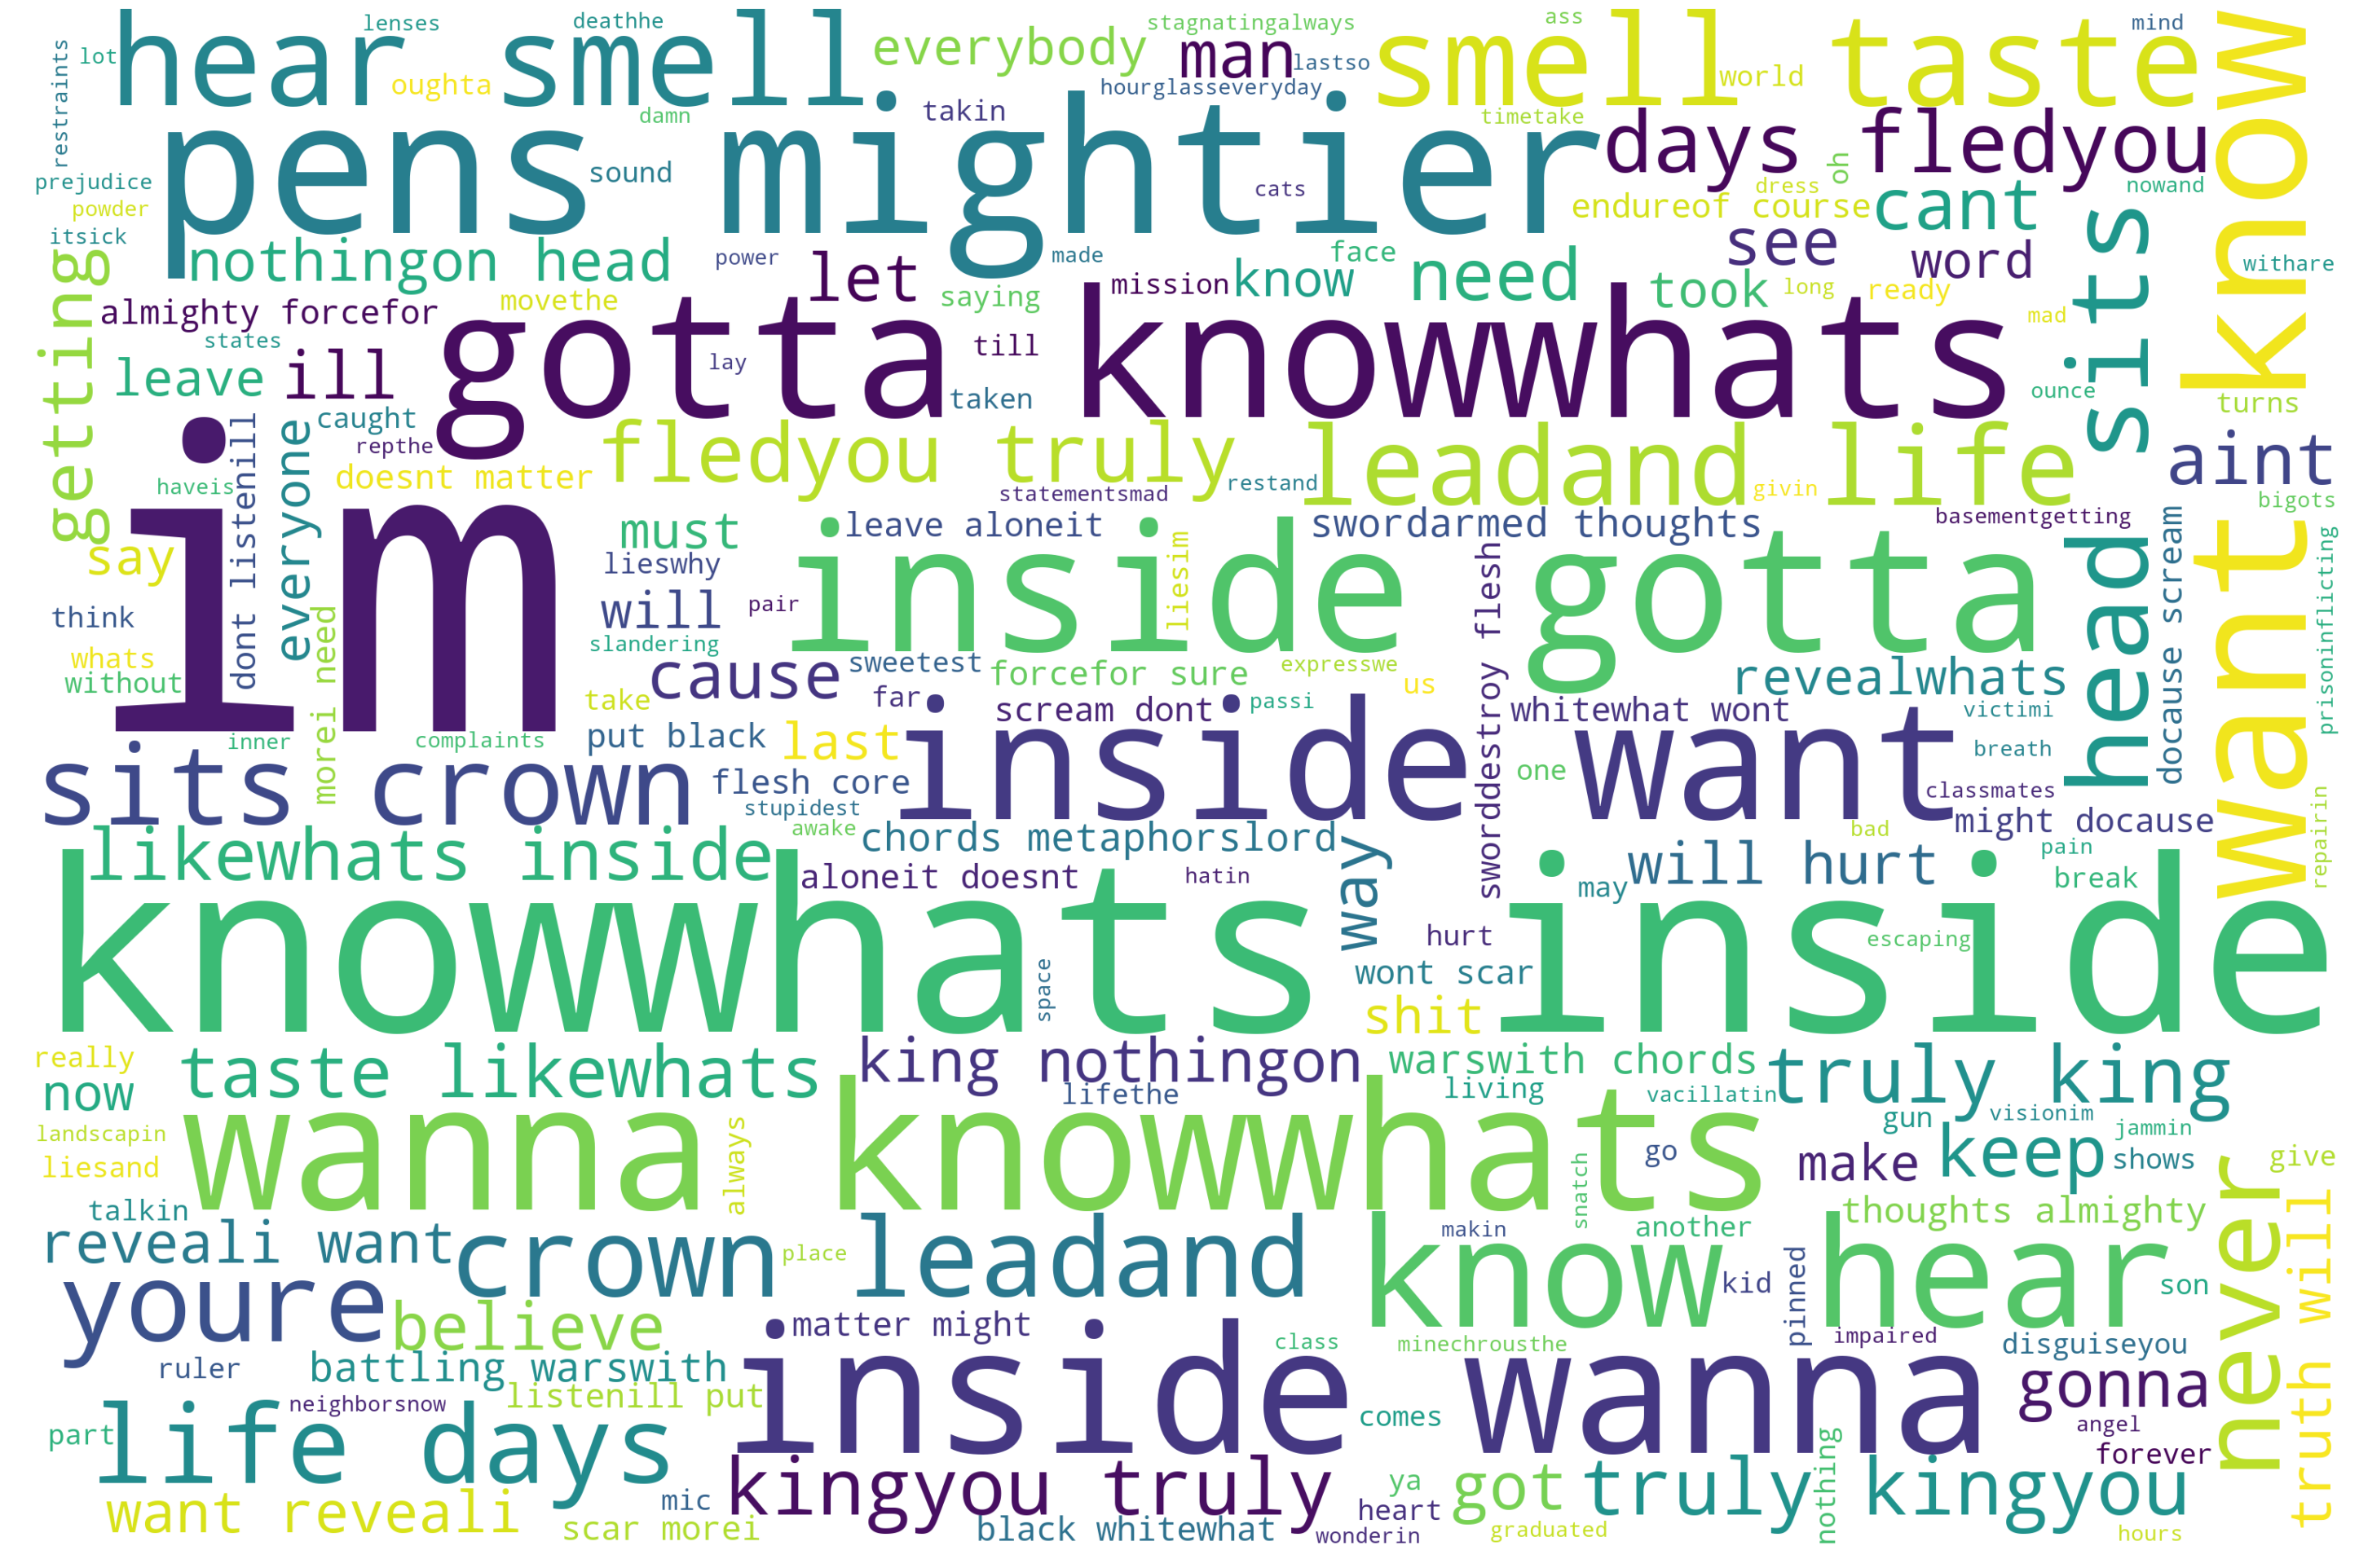

In [30]:
text = df_Rock.lyrics.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'white', edgecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()